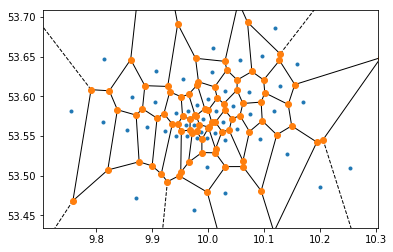

In [7]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas as pd
import numpy as np
import folium
from scipy.spatial import ConvexHull
from geojson import Polygon, Feature, FeatureCollection
from scipy.spatial.qhull import QhullError
from shapely import geometry  
import matplotlib.pyplot as plt
from datasciencetoolbox.utils.constants import distinct_colors

%matplotlib inline

# Hamburg centroids - extracted from K-means Hamburg
points = [[ 9.9988879,  53.5469112 ],
 [10.03065875, 53.60696891],
 [ 9.92325401, 53.55635768],
 [10.17082378, 53.59302025],
 [ 9.81170735, 53.56780098],
 [ 9.96519057, 53.58125503],
 [ 9.9814546 , 53.58849032],
 [10.20079404, 53.48615627],
 [10.0528331 , 53.55850337],
 [ 9.97547658, 53.56313417],
 [10.12902293, 53.61258197],
 [10.00769205, 53.63029276],
 [ 9.86386398, 53.59933508],
 [ 9.97603173, 53.45707055],
 [10.02734626, 53.56774048],
 [10.07347086, 53.60559946],
 [ 9.96257406, 53.54998047],
 [ 9.90579204, 53.59332008],
 [10.09611676, 53.65055211],
 [10.0938638 , 53.54553756],
 [ 9.95606   , 53.62108775],
 [ 9.81509693, 53.64673266],
 [ 9.98857069, 53.55524864],
 [ 9.85551914, 53.5578566 ],
 [ 9.99153776, 53.57113494],
 [10.01291219, 53.55355707],
 [ 9.87134888, 53.47188776],
 [10.01502931, 53.58101447],
 [10.16028414, 53.64082157],
 [10.00993529, 53.66071484],
 [ 9.89100368, 53.5610667 ],
 [ 9.96081458, 53.56376709],
 [10.04467708, 53.58770437],
 [10.11790799, 53.58091235],
 [10.00017862, 53.59680333],
 [ 9.9983175 , 53.5108937 ],
 [ 9.94230352, 53.55037496],
 [ 9.97971753, 53.54689071],
 [ 9.90673804, 53.63233404],
 [10.05711371, 53.64563434],
 [10.0749663 , 53.57731318],
 [10.11982295, 53.68530112],
 [10.03065568, 53.47831139],
 [10.03056174, 53.54432261],
 [10.14077248, 53.52695717],
 [ 9.75470985, 53.5810172 ],
 [ 9.94315455, 53.57908361],
 [10.25376771, 53.51000547]]


vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show();

In [13]:
def voronoi(centroids_lon_lat, boundary_box, print_map = True):
    """
    given cluster centroids create and print a voronoy diagram over folium map

    :param centroids_lon_lat: list containing centroids coordinates in the form [[lon,lat]]
    :param boundary_box: define polygon limit when drawing over folium as voronoy diagrams over earth could be infinite.
    Structure is in the following order [lon_lim_min,lat_lim_min,lon_lim_max,lat_lim_max]
    
    Example Usage:
    
    centroids = [[9.92325401, 53.55635768],
             [10.17082378, 53.59302025],
             [9.81170735, 53.56780098],
             [9.96519057, 53.58125503],
             [9.9814546, 53.58849032],
             [10.20079404, 53.48615627],
             [10.0528331, 53.55850337],
             [9.97547658, 53.56313417]]
             
    lon_lim_min = 9.70
    lat_lim_min = 53.42
    lon_lim_max = 10.36
    lat_lim_max = 53.75

    boundary_box = [lon_lim_min,lat_lim_min,lon_lim_max,lat_lim_max]

    voronoi(centroids,boundary_box) 
    """
    vor = Voronoi(centroids_lon_lat)
    
    bbx = geometry.Polygon([
        (boundary_box[0], boundary_box[1]),
        (boundary_box[2], boundary_box[1]),
        (boundary_box[2], boundary_box[3]),
        (boundary_box[0], boundary_box[3]),
        (boundary_box[0], boundary_box[1]),
        ])

    
    
    
    
    ###### process voronoy vertices and define infinite edges
    # reference: https://github.com/erikbern/ann-presentation/blob/master/voronoi.py
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    radius = None
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    new_vertices = np.asarray(new_vertices)
    polygons = []
    for new_region in new_regions:
        polygons.append(new_vertices[new_region])
    ######
    
    if(print_map):
        
        regions = polygons
        #regions = [(region_idx, vor.regions[region_idx]) for region_idx, r in enumerate(vor.regions)]
        geojson_list = []
        for region_id in range(len(regions)):
            region = regions[region_id]
            region_idx = region_id
            if region is not None:
                #region = list(filter(lambda elem: elem!=-1,region))
                coords = region
                if len(coords) > 2:
                    entry_properties = {"cluster_id": region_idx,
                                        "stroke": "#1f1a95",
                                        "stroke-opacity": 1,
                                        "stroke-width": 2,
                                        "color": distinct_colors[region_idx]}
                    coords = geometry.Polygon(coords).intersection(bbx).exterior.coords[:]

                    ft = Feature(geometry=Polygon([coords]), properties=entry_properties)

                    geojson_list.append(ft)
                else:
                    print('Cluster ' + str(region_idx) + ' not included. Less than 2 points after -1 values removed.' +
                          ' For more information please take a look at https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html')
        map_initial_lon_lat = [np.median([point[1] for point in centroids_lon_lat]), np.median([point[0] for point in centroids_lon_lat])] #lat/lon
        map_initial_zoom = 10


        feature_collection = FeatureCollection(geojson_list)
        map_osm = folium.Map(location=map_initial_lon_lat,
                                tiles = 'openstreetmap',
                                zoom_start = map_initial_zoom)

        f_json = folium.GeoJson(feature_collection,
            style_function=lambda x: {
                'weight' :5,
                "fill" : x['properties']["color"],
                'color' : x['properties']["color"]
                })

        map_osm.add_child(f_json)

        #plot centroid markers
    #     if(np.unique(cluster_centroids is None)[0] == False):
    #         cluster_centroids = cluster_centroids[np.argsort(cluster_centroids_ids)]
    #         if(cluster_centroids_labels is None):
    #             cluster_centroids_labels = [''] * len(points_labels_distinct)
    #         for cluster_centroid, point_labels_distinct_, label in zip(cluster_centroids,points_labels_distinct,cluster_centroids_labels):
    #             cluster_label = str(point_labels_distinct_) + ' ' + str(label)
    #             folium.Marker(cluster_centroid[::-1], popup=cluster_label).add_to(map_osm)

        display(map_osm)
    return polygons


# boundary box
lon_lim_min = 9.70
lat_lim_min = 53.42
lon_lim_max = 10.36
lat_lim_max = 53.75

boundary_box = [lon_lim_min,lat_lim_min,lon_lim_max,lat_lim_max]

polygons = voronoi(points,boundary_box, print_map = True)    
    